
# Parametric Curve Fitting — Estimating $\theta$, $M$, $X$  


## Imports

In [ ]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize

# make numpy prints predictable
np.set_printoptions(suppress=True, precision=6)



## Load dataset  


In [ ]:

# Path to your CSV; change if needed.
csv_path = "/content/xy_data.csv"  # e.g., upload to Colab or place locally

data = pd.read_csv(csv_path)

# Accept either named columns (t,x,y) or two-column (x,y)
cols_lower = [c.lower() for c in data.columns]
if "t" in cols_lower:
    t_vals = data[data.columns[cols_lower.index("t")]].to_numpy(dtype=float)
    x_obs = data[data.columns[cols_lower.index("x")]].to_numpy(dtype=float)
    y_obs = data[data.columns[cols_lower.index("y")]].to_numpy(dtype=float)
else:
    x_obs = data.iloc[:, 0].to_numpy(dtype=float)
    y_obs = data.iloc[:, 1].to_numpy(dtype=float)
    t_vals = np.linspace(6.0001, 59.9999, len(x_obs))

print(f"Loaded {len(t_vals)} points.")
display(data.head())


Loaded 1500 points.


,x,y
0,88.364456,57.784378
1,74.283936,54.406780
2,60.256474,46.311462
3,82.134370,57.717567
4,101.036390,67.849340



## Normalization


In [ ]:

x_mu, x_sd = x_obs.mean(), x_obs.std()
y_mu, y_sd = y_obs.mean(), y_obs.std()

x_norm = (x_obs - x_mu) / x_sd
y_norm = (y_obs - y_mu) / y_sd

print("x mean/std:", x_mu, x_sd)
print("y mean/std:", y_mu, y_sd)


x mean/std: 83.713931456 13.692590381934432
y mean/std: 58.263519255333335 7.693958166581763



##  Model definition


In [ ]:

def model_xy(params, t):
    theta, M, X = params
    exp_part = np.exp(M * np.abs(t))
    s03 = np.sin(0.3 * t)
    x_hat = t * np.cos(theta) - exp_part * s03 * np.sin(theta) + X
    y_hat = 42 + t * np.sin(theta) + exp_part * s03 * np.cos(theta)
    return x_hat, y_hat



## Objective: mean L1 error in normalized space


In [ ]:

def l1_loss(params):
    x_hat, y_hat = model_xy(params, t_vals)
    x_hat_n = (x_hat - x_mu) / x_sd
    y_hat_n = (y_hat - y_mu) / y_sd
    return np.mean(np.abs(x_norm - x_hat_n) + np.abs(y_norm - y_hat_n))



## Optimization setup  
We use **Differential Evolution** for global search, then **L-BFGS-B** for local refinement.


In [ ]:

theta_lo, theta_hi = 0.0, 50.0 * math.pi / 180.0
M_lo, M_hi = -0.05, 0.05
X_lo, X_hi = 0.0, 100.0
bounds = [(theta_lo, theta_hi), (M_lo, M_hi), (X_lo, X_hi)]

print("Running Differential Evolution...")
de_result = differential_evolution(
    func=lambda p: l1_loss(p),
    bounds=bounds,
    strategy="best1bin",
    popsize=30,
    maxiter=4000,
    tol=1e-8,
    polish=False,
    disp=True
)
de_result.x, de_result.fun


Running Differential Evolution...
differential_evolution step 1: f(x)= 2.347600390357408
differential_evolution step 2: f(x)= 2.347600390357408
differential_evolution step 3: f(x)= 2.346419535288427
differential_evolution step 4: f(x)= 2.346419535288427
differential_evolution step 5: f(x)= 2.3461601536513954
differential_evolution step 6: f(x)= 2.344064182679355
differential_evolution step 7: f(x)= 2.34402072764845
differential_evolution step 8: f(x)= 2.34402072764845
differential_evolution step 9: f(x)= 2.343902735027172
differential_evolution step 10: f(x)= 2.343540902467536
differential_evolution step 11: f(x)= 2.343540902467536
differential_evolution step 12: f(x)= 2.343540902467536
differential_evolution step 13: f(x)= 2.343540902467536
differential_evolution step 14: f(x)= 2.343540902467536
differential_evolution step 15: f(x)= 2.343540902467536
differential_evolution step 16: f(x)= 2.343538917857083
differential_evolution step 17: f(x)= 2.3435281556772387
differential_evolution 

(array([ 0.471929,  0.023537, 54.528054]), np.float64(2.3435246995784356))


##  Local refinement (L-BFGS-B)


In [ ]:

print("Refining with L-BFGS-B...")
lbfgs_result = minimize(
    fun=lambda p: l1_loss(p),
    x0=de_result.x,
    method="L-BFGS-B",
    bounds=bounds,
    options={"ftol": 1e-10, "maxiter": 10000}
)

theta, M, X = lbfgs_result.x
theta_deg = theta * 180.0 / math.pi
reduced_l1 = l1_loss([theta, M, X]) * len(t_vals)

print("Theta (rad):", theta)
print("Theta (deg):", theta_deg)
print("M         :", M)
print("X         :", X)
print("Reduced L1:", reduced_l1)


Refining with L-BFGS-B...
Theta (rad): 0.4719293830944818
Theta (deg): 27.03956187952639
M         : 0.02353675253010922
X         : 54.52805401205596
Reduced L1: 3515.287046761853


## Plot comparison

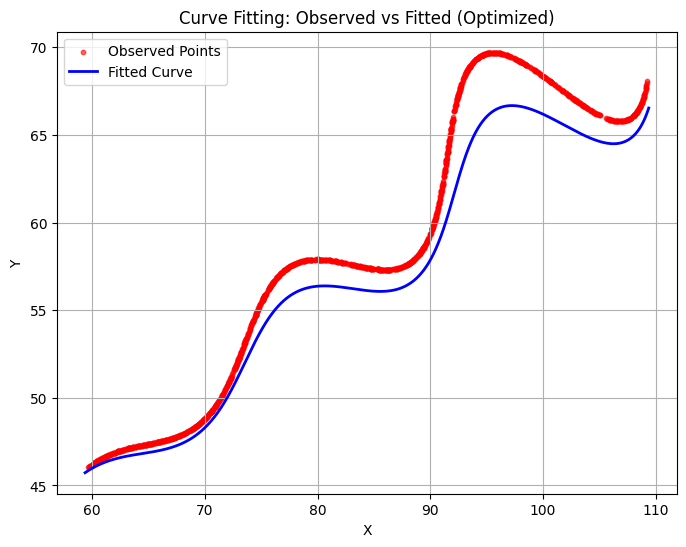

In [ ]:
x_pred, y_pred = model_xy([theta, M, X], t_vals)

plt.figure(figsize=(8,6))
plt.scatter(x_obs, y_obs, color='red', s=10, label='Observed Points', alpha=0.6)
plt.plot(x_pred, y_pred, color='blue', linewidth=2, label='Fitted Curve')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Curve Fitting: Observed vs Fitted (Optimized)")
plt.legend()
plt.grid(True)
plt.show()